## Using SlideRule with ICESat-2 data

This is a short Jupyter Notebook designed to show how SlideRule could be used to reduce noise in ICESat-2 ATL03 data. We will use Creamer's Field, AK as a testbed.

In [1]:
import logging
import concurrent.futures
import time
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
from sliderule import icesat2
from sliderule import sliderule

In [2]:
# Initialize the package
icesat2.init("slideruleearth.io", verbose=False)

The below cell contains bounding boxes for several SnowEx field sites across Alaska. The tutorial uses the code for Creamer's Field ('cffl').

In [3]:
# Define the region of interest. Currently given as 3 blocks of code, but will (hopefully) update this
# to use polygons instead.
# CPCRW = Caribou/Poker Creek
# CFFL = Creamer's Field/Farmer's Loop
# BCEF = Bonanza Creek
field_id = 'cffl'

if field_id == 'cpcrw':
    # Caribou/Poker Creek, AK
    region = [ {"lon":-147.66633, "lat": 65.114884},
               {"lon":-147.379038, "lat": 65.114884},
               {"lon":-147.379038, "lat": 65.252394},
               {"lon":-147.66633, "lat": 65.252394},
               {"lon":-147.66633, "lat": 65.114884} ]
elif field_id == 'cffl':
    # Creamer's Field/Farmer's Loop, AK
    region = [ {"lon":-147.750873, "lat": 64.858387},
               {"lon":-147.661642, "lat": 64.858901},
               {"lon":-147.661642, "lat": 64.888732},
               {"lon":-147.750873, "lat": 64.888732},
               {"lon":-147.750873, "lat": 64.858387} ]
elif field_id == 'bcef':
    # Bonanza Creek, AK
    region = [ {"lon":-148.337216, "lat": 64.687819},
               {"lon":-148.243277, "lat": 64.687819},
               {"lon":-148.243277, "lat": 64.749681},
               {"lon":-148.337216, "lat": 64.749681},
               {"lon":-148.337216, "lat": 64.687819} ]
elif field_id == 'acp':
    # Arctic Coastal Plain, AK
    region = [ {"lon":-148.85, "lat": 69.985},
               {"lon":-148.527, "lat": 69.985},
               {"lon":-148.527, "lat": 70.111},
               {"lon":-148.85, "lat": 70.111},
               {"lon":-148.85, "lat": 69.985} ]
else:
    raise ValueError('Field ID not recognized.')

We are now going to build TWO SlideRule requests over Creamer's Field. The first one will include all signal photons (high, medium, low) and will not filter out tree canopies. The second query will only include high-confidence signal photons that are recognized as "ground" photons by the ATL08 algorithm.

In [4]:
# Build first request with the specified parameters
parms = {
    "poly": region,
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_LOW,
    "ats": 5.0,
    "len": 20.0,
    "res": 10.0,
    "maxi": 5
}

# Request ATL06 Data (first request)
df = icesat2.atl06p(parms, "nsidc-s3")

# Build second request
parms = {
    "poly": region,
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_HIGH,
    "atl08_class": ["atl08_ground"],
    "ats": 5.0,
    "len": 20.0,
    "res": 10.0,
    "maxi": 5
}

df2 = icesat2.atl06p(parms, "nsidc-s3")

In [5]:
df.head()

,delta_time,w_surface_window_final,cycle,h_sigma,rms_misfit,n_fit_photons,dh_fit_dy,distance,dh_fit_dx,h_mean,spot,gt,pflags,rgt,segment_id,geometry
time,,,,,,,,,,,,,,,,
2018-12-26 10:12:40.750601636,3.105436e+07,4.581222,1,0.093835,0.648938,48,0.0,1.283867e+07,-0.102509,181.695179,2,50,0,1356,640984,POINT (-147.66165 64.87788)
2018-12-26 10:12:40.752005712,3.105436e+07,5.580595,1,0.116315,0.855787,55,0.0,1.283868e+07,-0.018369,181.151198,2,50,0,1356,640985,POINT (-147.66167 64.87779)
2018-12-26 10:12:40.753409008,3.105436e+07,5.983057,1,0.123141,0.840070,50,0.0,1.283869e+07,-0.104481,180.575270,2,50,0,1356,640985,POINT (-147.66169 64.87771)
2018-12-26 10:12:40.754814064,3.105436e+07,6.286084,1,0.141407,0.995515,53,0.0,1.283870e+07,-0.019761,180.050043,2,50,0,1356,640986,POINT (-147.66171 64.87762)
2018-12-26 10:12:40.756216120,3.105436e+07,6.627929,1,0.133668,1.092614,67,0.0,1.283871e+07,-0.066428,179.681218,2,50,0,1356,640986,POINT (-147.66174 64.87753)


In [6]:
df2.head()

,delta_time,w_surface_window_final,cycle,h_sigma,rms_misfit,n_fit_photons,dh_fit_dy,distance,dh_fit_dx,h_mean,spot,gt,pflags,rgt,segment_id,geometry
time,,,,,,,,,,,,,,,,
2018-12-26 10:12:40.750601624,3.105436e+07,3.0,1,0.065604,0.300443,21,0.0,1.283867e+07,-0.097217,181.803914,2,50,0,1356,640984,POINT (-147.66165 64.87788)
2018-12-26 10:12:40.752005728,3.105436e+07,3.0,1,0.052051,0.254097,26,0.0,1.283868e+07,-0.081698,180.890072,2,50,0,1356,640985,POINT (-147.66167 64.87779)
2018-12-26 10:12:40.753409008,3.105436e+07,3.0,1,0.041413,0.208376,27,0.0,1.283869e+07,-0.078502,180.101269,2,50,0,1356,640985,POINT (-147.66169 64.87771)
2018-12-26 10:12:40.754814056,3.105436e+07,3.0,1,0.044461,0.238447,30,0.0,1.283870e+07,-0.038319,179.518172,2,50,0,1356,640986,POINT (-147.66171 64.87762)
2018-12-26 10:12:40.756216116,3.105436e+07,3.0,1,0.036761,0.206558,32,0.0,1.283871e+07,-0.013889,179.208276,2,50,0,1356,640986,POINT (-147.66174 64.87753)


There's a few things that we can notice right away from the above DataFrame previews. First, the "h_sigma" parameter, i.e. the uncertainty in the approximated surface height, is lower in the second DataFrame. As a consequence, the surface height (elevation) estimate ("h_mean") differs by several decimeters between the two queries. We will look at this in more detail.

Just for reference, let's take a look at the coverage of Creamer's Field from all tracks since 2018.

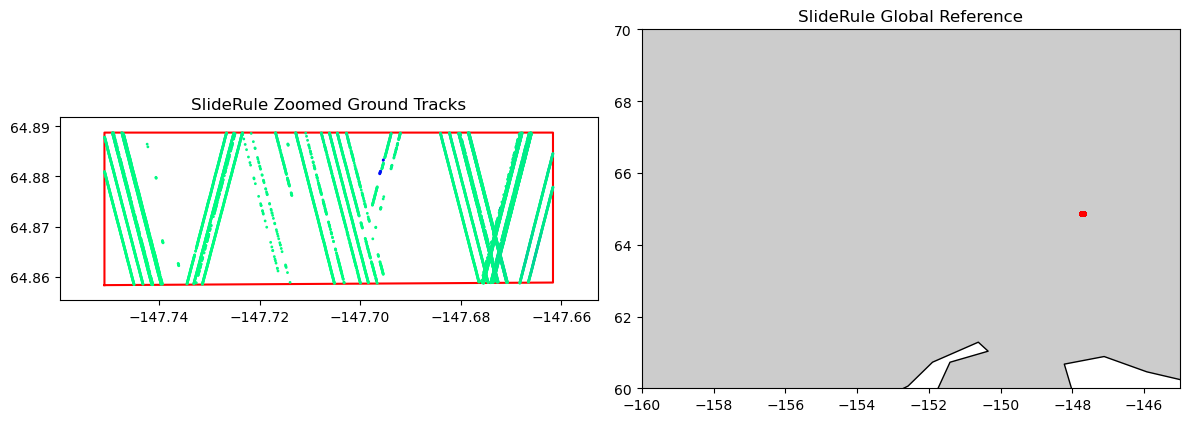

In [7]:
# Sample plot for all of the ICESat-2 tracks since its launch

# Calculate Extent
lons = [p["lon"] for p in region]
lats = [p["lat"] for p in region]
lon_margin = (max(lons) - min(lons)) * 0.1
lat_margin = (max(lats) - min(lats)) * 0.1

# Create Plot
fig,(ax1,ax2) = plt.subplots(num=None, ncols=2, figsize=(12, 6))
box_lon = [e["lon"] for e in region]
box_lat = [e["lat"] for e in region]

# Plot SlideRule Ground Tracks
ax1.set_title("SlideRule Zoomed Ground Tracks")
df.plot(ax=ax1, column=df["h_mean"], cmap='winter_r', s=1.0, zorder=3)
ax1.plot(box_lon, box_lat, linewidth=1.5, color='r', zorder=2)
ax1.set_xlim(min(lons) - lon_margin, max(lons) + lon_margin)
ax1.set_ylim(min(lats) - lat_margin, max(lats) + lat_margin)
ax1.set_aspect('equal', adjustable='box')

# Plot SlideRule Global View
ax2.set_title("SlideRule Global Reference")
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax2, color='0.8', edgecolor='black')
df.plot(ax=ax2, marker='o', color='red', markersize=2.5, zorder=3)
ax2.set_xlim(-160,-145)
ax2.set_ylim(60,70)
ax2.set_aspect('equal', adjustable='box')

# Show Plot
plt.tight_layout()

The Creamer's Field site is fairly small, so there are only a few ICESat-2 tracks that fly over (without TOOs). To keep thigs simple, let's look at just one of the tracks: RGT 266.

In [21]:
# Set up a dataframe that is only applicable for an RGT of interest
rgt = 266
rgt_pd = df[df['rgt']==rgt]
rgt_pd2 = df2[df2['rgt']==rgt]

np.shape(rgt_pd2.loc['2021-07'])

(457, 16)

Let's take a look at the height comparisons between our two queries. The below plots show (a) the along-track surface height in July 2021, and (b) the uncertainty ("h_sigma") along the same track.

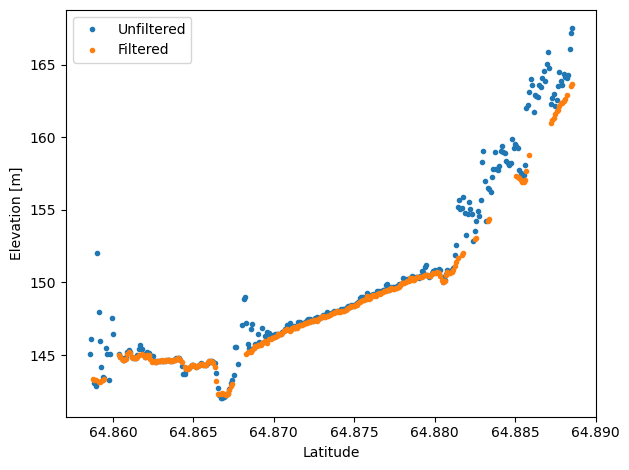

In [43]:
# Only look at the central beam, for simplicity
rgt_pd_ctr = rgt_pd[rgt_pd['gt']==40]
rgt_pd_ctr2 = rgt_pd2[rgt_pd2['gt']==40]

#np.shape(rgt_pd_ctr2)

#%matplotlib inline
plt.plot(rgt_pd_ctr.geometry.y.loc['2021-07'], rgt_pd_ctr['h_mean'].loc['2021-07'], '.', label='Unfiltered')
plt.plot(rgt_pd_ctr2.geometry.y.loc['2021-07'], rgt_pd_ctr2['h_mean'].loc['2021-07'], '.', label='Filtered')
plt.xlabel('Latitude')
plt.ylabel('Elevation [m]')
plt.legend()
plt.tight_layout()
plt.show()

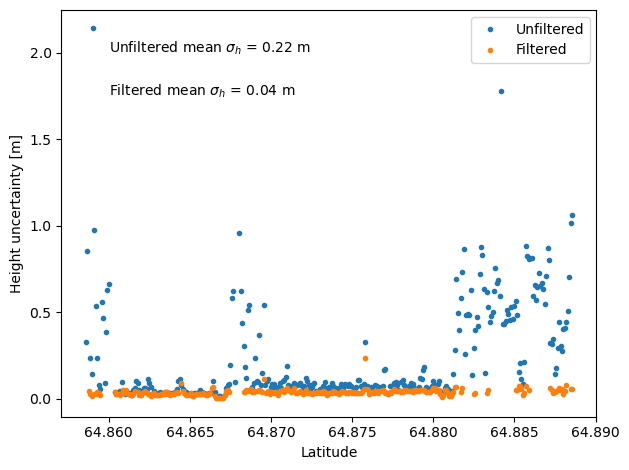

In [50]:
uf_sigma_mean = rgt_pd_ctr['h_sigma'].loc['2021-07'].mean()
f_sigma_mean = rgt_pd_ctr2['h_sigma'].loc['2021-07'].mean()

plt.plot(rgt_pd_ctr.geometry.y.loc['2021-07'], rgt_pd_ctr['h_sigma'].loc['2021-07'], '.', label='Unfiltered')
plt.plot(rgt_pd_ctr2.geometry.y.loc['2021-07'], rgt_pd_ctr2['h_sigma'].loc['2021-07'], '.', label='Filtered')
plt.xlabel('Latitude')
plt.ylabel('Height uncertainty [m]')
plt.text(64.86, 2, 'Unfiltered mean $\sigma_h$ = {:.2f} m'.format(uf_sigma_mean))
plt.text(64.86, 1.75, 'Filtered mean $\sigma_h$ = {:.2f} m'.format(f_sigma_mean))
plt.legend()
plt.tight_layout()
plt.show()

Looking at these plots, it is obvious that limiting our ICESat-2 data to only high-confidence ground photons reduces noise significantly. At least over Creamer's Field, this appears to be caused by vegetation, as the along-track elevation profile shows elevations several meters above the ground in the unfiltered profile.

Creamer's Field is highly vegetated, so a difference is expected when we are more selective with our photons. Over flatter, less vegetated terrain, such as the Arctic Coastal Plain of Alaska, the differences may not be quite as significant.

In [9]:
# Save the DataFrame to a CSV file
rgt_pd2.to_csv(r'is2_atl03sl_%s_rgt%s.csv' %(field_id, rgt))